# Solar Yield Relationships with Darts

This notebook builds a simple model that relates weather and time features to `solar_yield` (the summed solar columns).
No lag features are used; only contemporaneous covariates are included.

In [3]:
import sys
from pathlib import Path

# Walk upwards until we find the repo root (where "common" lives)
p = Path.cwd()
while p != p.parent and not (p / "common").exists():
    p = p.parent
sys.path.insert(0, str(p))

import os
import pandas as pd

from common.db_repository import DbRepository
from predicthelper import PredictHelper


In [4]:
from pathlib import Path
from dotenv import load_dotenv

# Find repo root (where env.local lives)
p = Path.cwd()
while p != p.parent and not (p / "env.local").exists():
    p = p.parent

load_dotenv(p / "env.local")
print("Loaded env.local:", p / "env.local")


Loaded env.local: /home/gerbrand/PycharmProjects/EnergySchedulerNuc/env.local


## Load and Build the Feature DataFrame
This pulls the hourly-aggregated data from the database and adds time features.

In [5]:
repo = DbRepository(connection_string=os.environ.get("energydb"))
rows = repo.get_hourly_solar_with_weather()
repo.close()

helper = PredictHelper()
df = helper.build_feature_dataframe(rows)

# Clean up any missing data
df = df.dropna().sort_values("Timestamp").reset_index(drop=True)

# Normalize timestamps to UTC and drop tz for Darts
df["Timestamp"] = pd.to_datetime(df["Timestamp"], utc=True)
df["Timestamp"] = df["Timestamp"].dt.tz_convert("UTC").dt.tz_localize(None)
df.head(1000)


,Timestamp,solar_total,pressure,temperature,cloud_are_fraction,precipitation,humidity,wind_from_direction,wind_speed,Sun_Angle,Sun_Angle_Trend,hour_sin,hour_cos,wd_sin,wd_cos
0,2025-05-11 20:00:00,0.00,1011.799988,17.500000,0.000000,0.0,54.000000,88.900002,3.7,0.000000,-1,-5.000000e-01,0.866025,-0.781831,0.62349
1,2025-05-11 21:00:00,0.00,1011.900024,16.900000,0.000000,0.0,56.299999,105.300003,3.5,0.000000,-1,-2.588190e-01,0.965926,-0.781831,0.62349
2,2025-05-11 22:00:00,0.00,1012.099976,15.900000,0.000000,0.0,62.799999,99.199997,3.4,0.000000,-1,0.000000e+00,1.000000,0.000000,1.00000
3,2025-05-11 23:00:00,0.00,1012.000000,15.500000,0.000000,0.0,65.699997,101.500000,3.6,0.000000,-1,2.588190e-01,0.965926,0.000000,1.00000
4,2025-05-12 00:00:00,0.00,1012.099976,14.700000,0.000000,0.0,69.000000,106.500000,3.8,0.000000,-1,5.000000e-01,0.866025,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2025-06-24 07:00:00,0.03,1012.799988,17.799999,53.099998,0.0,64.599998,245.100006,4.8,0.433155,1,7.071068e-01,-0.707107,0.781831,0.62349
996,2025-06-24 08:00:00,0.03,1012.700012,18.500000,82.800003,0.0,62.000000,246.600006,5.8,0.593989,1,5.000000e-01,-0.866025,0.781831,0.62349
997,2025-06-24 09:00:00,0.05,1012.700012,18.700001,96.900002,0.0,62.400002,241.800003,6.2,0.751610,1,2.588190e-01,-0.965926,0.781831,0.62349
998,2025-06-24 10:00:00,0.03,1012.799988,19.200001,96.900002,0.0,60.700001,235.899994,6.3,0.895911,1,1.224647e-16,-1.000000,0.781831,0.62349


## Build Darts TimeSeries
We use the solar total as the target and all other features as covariates.

In [6]:
from darts import TimeSeries

target_col = "solar_total"
feature_cols = [
    "pressure",
    "temperature",
    "cloud_are_fraction",
    "precipitation",
    "humidity",
    "wind_from_direction",
    "wind_speed",
    "Sun_Angle",
    "Sun_Angle_Trend",
    "hour_sin",
    "hour_cos",
    "wd_sin",
    "wd_cos",
]


# Infer frequency; default to hourly if it cannot be inferred
freq = pd.infer_freq(df["Timestamp"]) or "h"
# Ensure continuous index and impute missing values
df = df.set_index("Timestamp").asfreq(freq)
df = df.interpolate(method="time").ffill().bfill()
df = df.reset_index()

series = TimeSeries.from_dataframe(
    df,
    time_col="Timestamp",
    value_cols=target_col,
    fill_missing_dates=True,
    freq=freq,
)
covariates = TimeSeries.from_dataframe(
    df,
    time_col="Timestamp",
    value_cols=feature_cols,
    fill_missing_dates=True,
    freq=freq,
)


## Train / Validation Split

In [7]:
split_index = int(len(df) * 0.8)
split_time = df.loc[split_index, "Timestamp"]

train, val = series.split_after(split_time)
train_cov, val_cov = covariates.split_after(split_time)


## Fit a Simple Darts Model
We use a linear regression with *only contemporaneous covariates* (lag 0) to keep it simple.

In [8]:
from darts.models import LinearRegressionModel

model = LinearRegressionModel(
    lags=None,
    lags_future_covariates=[0],
)

model.fit(train, future_covariates=train_cov)
pred = model.predict(n=len(val), future_covariates=val_cov)


In [9]:
from pathlib import Path

model_dir = Path("..") / "Models"
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / "solar_yield_model"
model.save(str(model_path))
model_path


PosixPath('../Models/solar_yield_model')

## Quick Evaluation

MAE: 0.007584588797599627


<Axes: xlabel='Timestamp'>

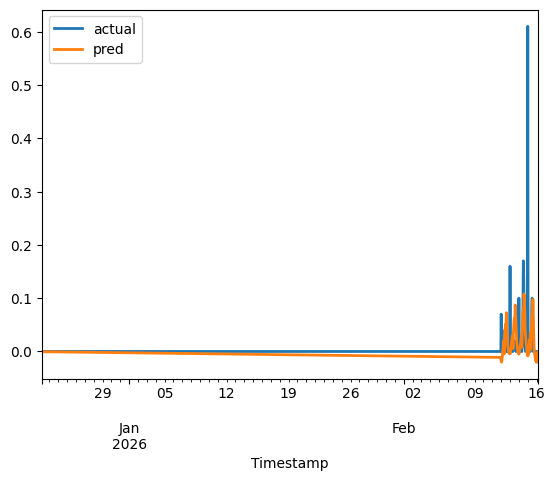

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["timezone"] = "Europe/Amsterdam"

from darts.metrics import mae

print("MAE:", mae(val, pred))
val.plot(label="actual")
pred.plot(label="pred")


## Coefficients (Relationship Strengths)
For a linear regression, coefficients show how each feature relates to `solar_total`.
If the attribute is not present, try `model._model` instead of `model.model`.

In [8]:
sk_model = getattr(model, "model", None) or getattr(model, "_model", None)
coefs = pd.Series(sk_model.coef_.ravel(), index=feature_cols).sort_values(ascending=False)
coefs


Sun_Angle              0.111999
wind_from_direction    0.000013
cloud_are_fraction    -0.000110
wd_sin                -0.000146
pressure              -0.000228
wd_cos                -0.000285
temperature           -0.000769
humidity              -0.001051
hour_sin              -0.001861
wind_speed            -0.002502
precipitation         -0.008179
Sun_Angle_Trend       -0.016946
hour_cos              -0.025184
dtype: float64